In [630]:
%pip install sortedcontainers

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [631]:
#import das bibliotecas necessárias
import matplotlib.pyplot as plt
from functools import cmp_to_key
import numpy as np
import random
from sortedcontainers import SortedList

In [632]:
def orientation(p, q, r):
    """
    Para determinar a orientação do conjunto ordenado (p, q, r).
    Se o resultado for positivo, então a orientação é no sentido horário.
    Se o resultado for negativo, então a orientação é no sentido anti-horário.
    Se o resultado for 0, então p, q e r são colineares.
    """
    return (q.y - p.y) * (r.x - q.x) - (q.x - p.x) * (r.y - q.y)

def on_segment(p, q, r):
    """Verifica se o ponto q está no segmento definido pelos pontos p e r."""
    return (q.x <= max(p.x, r.x) and q.x >= min(p.x, r.x) and
            q.y <= max(p.y, r.y) and q.y >= min(p.y, r.y))

def intersect(p1, q1, p2, q2):
    # Esta função determina se o segmento p1q1 cruza com p2q2.
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)

    if o1 != o2 and o3 != o4:
        return True

    # Casos especiais
    if o1 == 0 and on_segment(p1, p2, q1): return True
    if o2 == 0 and on_segment(p1, q2, q1): return True
    if o3 == 0 and on_segment(p2, p1, q2): return True
    if o4 == 0 and on_segment(p2, q1, q2): return True

    return False

In [633]:
class Ponto:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __sub__(self, other):
        return Ponto(self.x - other.x, self.y - other.y)

    def __repr__(self):
        return f"({self.x}, {self.y})"

    def distancia_ao_quadrado(self, other):
        return (self.x - other.x)**2 + (self.y - other.y)**2

class Segmento:
    def __init__(self, p1, p2):
        self.p1 = p1
        self.p2 = p2
    def __repr__(self):
        return f"[{self.p1}, {self.p2}]"
    
    def __hash__(self):
        return hash((self.p1, self.p2))
    
    def __eq__(self, other):
        return isinstance(other, Segmento) and {self.p1, self.p2} == {other.p1, other.p2}
    
    def intersecao(self, other):
        o1 = orientation(self.p1, self.p2, other.p1)
        o2 = orientation(self.p1, self.p2, other.p2)
        o3 = orientation(other.p1, other.p2, self.p1)
        o4 = orientation(other.p1, other.p2, self.p2)

        # Condições principais de interseção
        if o1 * o2 < 0 and o3 * o4 < 0:
            return True

        # Casos especiais: se os segmentos são colineares e se cruzam
        if o1 == 0 and on_segment(self.p1, other.p1, self.p2):
            return True
        if o2 == 0 and on_segment(self.p1, other.p2, self.p2):
            return True
        if o3 == 0 and on_segment(other.p1, self.p1, other.p2):
            return True
        if o4 == 0 and on_segment(other.p1, self.p2, other.p2):
            return True

        return False


    
    def produto_vetorial(self, other):
        return (self.p2.x - self.p1.x) * (other.p2.y - other.p1.y) - (self.p2.y - self.p1.y) * (other.p2.x - other.p1.x)
    
    def __lt__(self, other):
        return self.p1.y < other.p1.y or (self.p1.y == other.p1.y and self.p2.y < other.p2.y)

    def __eq__(self, other):
        return self.p1.y == other.p1.y and self.p2.y == other.p2.y

In [634]:
def ordenacao_polar(p0):
    def compare(p1, p2):
        o = orientation(p0, p1, p2)
        if o == 0:
            return (p1.distancia_ao_quadrado(p0) <= p2.distancia_ao_quadrado(p0)) - 1
        return 1 if o > 0 else -1
    return compare


In [635]:
#Algoritmo de Graham Scan para criar a envoltoŕia convexa

def graham_scan(pontos):
    pontos = sorted(pontos, key=lambda p: (p.y, p.x))
    p0 = pontos[0]
    pontos_ordenados = sorted(pontos[1:], key=cmp_to_key(ordenacao_polar(p0)))

    envoltoria = [p0, pontos_ordenados[0]]
    for p in pontos_ordenados[1:]:
        # Enquanto a orientação não for anti-horária, remova o último ponto
        while len(envoltoria) > 1 and Segmento(envoltoria[-2], envoltoria[-1]).produto_vetorial(Segmento(envoltoria[-1], p)) <= 0:
            envoltoria.pop()
        envoltoria.append(p)

    # Fechar a envoltória
    if len(envoltoria) > 2:
        envoltoria.append(p0)

    return envoltoria


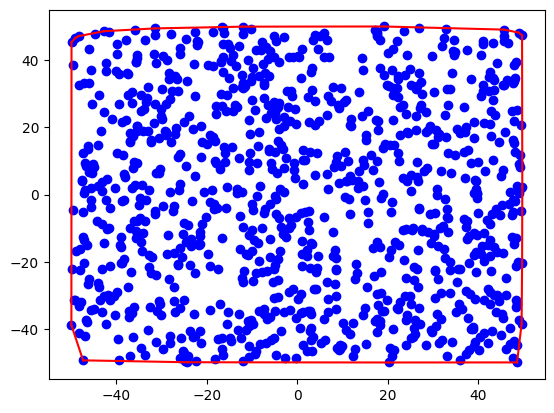

In [636]:
# Função para plotar a envoltória convexa

def plot_envoltoria(pontos, envoltoria):
    # Plotar todos os pontos
    plt.scatter([p.x for p in pontos], [p.y for p in pontos], color='b')

    # Plotar a envoltória convexa
    for i in range(len(envoltoria) - 1):
        plt.plot([envoltoria[i].x, envoltoria[i+1].x], [envoltoria[i].y, envoltoria[i+1].y], color='r')
    
    # Fechar a envoltória
    plt.plot([envoltoria[-1].x, envoltoria[0].x], [envoltoria[-1].y, envoltoria[0].y], color='r')
    
    plt.show()

# Gerar pontos aleatórios para testar o algoritmo e posteriormente plotar a envoltória convexa
pontos = [Ponto(random.uniform(-50, 50), random.uniform(-50, 50)) for _ in range(1000)]
envoltoria = graham_scan(pontos)
plot_envoltoria(pontos, envoltoria)

In [637]:
def segmentos_que_se_cruzam(segmentos, poligonos):
    # Criar eventos
    eventos = []
    for seg, poligono in zip(segmentos, poligonos):
        start = seg.p1 if seg.p1.x < seg.p2.x else seg.p2
        end = seg.p2 if seg.p1.x < seg.p2.x else seg.p1
        eventos.append((start, 'start', seg, poligono))
        eventos.append((end, 'end', seg, poligono))
    
    # Ordenar eventos
    eventos.sort(key=lambda e: (e[0].x, e[0].y))

    def order_by_y(segment):
        return (segment.p1.y + segment.p2.y) / 2

    ordenacao_y = SortedList(key=order_by_y)
    intersecoes = set()

    # Processar eventos
    for ponto, tipo, segmento, poligono in eventos:
        if tipo == 'start':
            idx = ordenacao_y.bisect(segmento)
            
            # Verificar interseção com segmento abaixo
            if idx > 0:
                seg_below = ordenacao_y[idx - 1]
                if segmento.intersecao(seg_below) and poligonos[segmentos.index(segmento)] != poligonos[segmentos.index(seg_below)]:
                    intersecoes.add(tuple(sorted([segmento, seg_below])))

            # Verificar interseção com segmento acima
            if idx < len(ordenacao_y) - 1:
                seg_above = ordenacao_y[idx + 1]
                if segmento.intersecao(seg_above) and poligonos[segmentos.index(segmento)] != poligonos[segmentos.index(seg_above)]:
                    intersecoes.add(tuple(sorted([segmento, seg_above])))

            ordenacao_y.add(segmento)
        else:
            if segmento in ordenacao_y:  # Verificação adicionada
                segmento_idx = ordenacao_y.index(segmento)
                
                # Verificar interseção entre segmentos vizinhos
                if 0 < segmento_idx < len(ordenacao_y) - 1:
                    seg_below = ordenacao_y[segmento_idx - 1]
                    seg_above = ordenacao_y[segmento_idx + 1]
                    if seg_below.intersecao(seg_above) and poligonos[segmentos.index(seg_below)] != poligonos[segmentos.index(seg_above)]:
                        intersecoes.add(tuple(sorted([seg_below, seg_above])))
                
                ordenacao_y.remove(segmento)
    
    return list(intersecoes)

In [638]:
def ponto_dentro_poligono(p, poligono):
    n = len(poligono)
    intersecao = False
    p1 = poligono[0]
    for i in range(1, n + 1):
        p2 = poligono[i % n]
        if p.y > min(p1.y, p2.y):
            if p.y <= max(p1.y, p2.y):
                if p.x <= max(p1.x, p2.x):
                    if p1.y != p2.y:
                        x_inters = (p.y - p1.y) * (p2.x - p1.x) / (p2.y - p1.y) + p1.x
                    if p1.x == p2.x or p.x <= x_inters:
                        intersecao = not intersecao
        p1 = p2
    return intersecao


def verificar_separabilidade_linear(classe_1, classe_2):
    envoltoria_classe_1 = graham_scan(classe_1)
    envoltoria_classe_2 = graham_scan(classe_2)

    segmentos_classe_1 = [Segmento(envoltoria_classe_1[i], envoltoria_classe_1[i + 1]) for i in range(len(envoltoria_classe_1) - 1)]
    segmentos_classe_2 = [Segmento(envoltoria_classe_2[i], envoltoria_classe_2[i + 1]) for i in range(len(envoltoria_classe_2) - 1)]

    todos_os_segmentos = segmentos_classe_1 + segmentos_classe_2
    poligonos = [1] * len(segmentos_classe_1) + [2] * len(segmentos_classe_2)

    print(todos_os_segmentos)

    intersecoes = segmentos_que_se_cruzam(todos_os_segmentos, poligonos)
    return len(intersecoes) == 0


In [639]:
def plot_separabilidade(classe_1, classe_2):

    classe_1 = graham_scan(classe_1)
    classe_2 = graham_scan(classe_2)
    print(classe_1)
    print(classe_2)

    # Verificar se os dados são linearmente separáveis
    separaveis = verificar_separabilidade_linear(classe_1, classe_2)
    
    # Plotar envoltória da classe 1
    for i in range(len(classe_1) - 1):
        plt.plot([classe_1[i].x, classe_1[i + 1].x], 
                 [classe_1[i].y, classe_1[i + 1].y], 'b-')
    
    # Plotar envoltória da classe 2
    for i in range(len(classe_2) - 1):
        plt.plot([classe_2[i].x, classe_2[i + 1].x], 
                 [classe_2[i].y, classe_2[i + 1].y], 'r-')
    
    if separaveis:
        plt.title("Dados são linearmente separáveis!")
    else:
        plt.title("Dados não são linearmente separáveis!")
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

[(3, 1), (9, 3), (10, 10), (5, 9), (3, 1)]
[(13, 6), (12, 9), (10, 14), (7, 15), (6, 10), (13, 6)]
[[(3, 1), (9, 3)], [(9, 3), (10, 10)], [(10, 10), (5, 9)], [(5, 9), (3, 1)], [(3, 1), (3, 1)], [(13, 6), (12, 9)], [(12, 9), (10, 14)], [(10, 14), (7, 15)], [(7, 15), (6, 10)], [(6, 10), (13, 6)], [(13, 6), (13, 6)]]


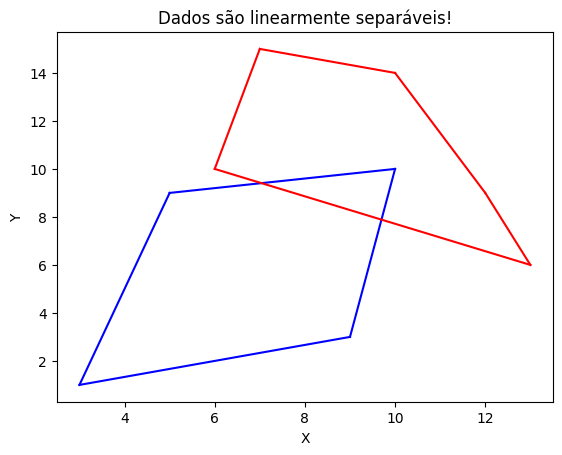

In [640]:
# Gerar pontos aleatórios para ambas as classes
classe_1_random = [Ponto(random.randint(0, 10), random.randint(0, 10)) for _ in range(3)]
classe_2_random = [Ponto(random.randint(5, 15), random.randint(5, 15)) for _ in range(3)]

classe_1_random = (5, 9), (9, 3), (10, 10), (7, 8), (3, 1)
classe_1_random = [Ponto(x, y) for x, y in classe_1_random]
classe_2_random = (12, 9), (10, 14), (6, 10), (7, 15), (13, 6)
classe_2_random = [Ponto(x, y) for x, y in classe_2_random]
# Utilizar a função para plotar as envoltórias e verificar separabilidade
plot_separabilidade(classe_1_random, classe_2_random)

In [641]:
def encontrar_pontos_mais_proximos(env1, env2):
    menor_distancia = float('inf')
    ponto1 = None
    ponto2 = None

    for p1 in env1:
        for p2 in env2:
            distancia = p1.distancia_ao_quadrado(p2)
            if distancia < menor_distancia:
                menor_distancia = distancia
                ponto1 = p1
                ponto2 = p2

    return ponto1, ponto2

def construir_modelo_linear(pontos1, pontos2):
    env1 = graham_scan(pontos1)
    env2 = graham_scan(pontos2)

    if not verificar_separabilidade_linear(env1, env2):
        print('Os dados não são linearmente separáveis.')
        return None

    ponto1, ponto2 = encontrar_pontos_mais_proximos(env1, env2)

    ponto_medio = Ponto((ponto1.x + ponto2.x) / 2, (ponto1.y + ponto2.y) / 2)
    vetor_direcao = Ponto(ponto2.x - ponto1.x, ponto2.y - ponto1.y)
    vetor_direcao_perpendicular = Ponto(vetor_direcao.y, -vetor_direcao.x)

    if vetor_direcao_perpendicular.x == 0:
        return 'vertical', ponto_medio.x, env1, env2
    else:
        m = vetor_direcao_perpendicular.y / vetor_direcao_perpendicular.x
        b = ponto_medio.y - m * ponto_medio.x
        return m, b, env1, env2

def plot_modelo(pontos1, pontos2):
    resultado = construir_modelo_linear(pontos1, pontos2)

    if resultado is None:
        return None
    
    modelo, b, env1, env2 = resultado

    ponto1, ponto2 = encontrar_pontos_mais_proximos(env1, env2)
    plt.fill([p.x for p in env1], [p.y for p in env1], color='blue', alpha=0.3)
    plt.fill([p.x for p in env2], [p.y for p in env2], color='red', alpha=0.3)
    plt.plot([p.x for p in env1 + [env1[0]]], [p.y for p in env1 + [env1[0]]], 'b-')
    plt.plot([p.x for p in env2 + [env2[0]]], [p.y for p in env2 + [env2[0]]], 'r-')
    plt.plot([ponto1.x, ponto2.x], [ponto1.y, ponto2.y], 'g--')
    
    if modelo == 'vertical':
        plt.axvline(x=b, color='c', label='Modelo Linear')
    else:
        m = modelo
        x_vals = [min([p.x for p in env1 + env2]), max([p.x for p in env1 + env2])]
        y_vals = [m*x+b for x in x_vals]
        plt.plot(x_vals, y_vals, 'c-', label='Modelo Linear')

    plt.legend()
    plt.show()


[[(10, 3), (0, 10)], [(0, 10), (2, 6)], [(2, 6), (6, 4)], [(6, 4), (10, 3)], [(10, 3), (10, 3)], [(14, 6), (13, 13)], [(13, 13), (8, 9)], [(8, 9), (9, 8)], [(9, 8), (14, 6)], [(14, 6), (14, 6)]]


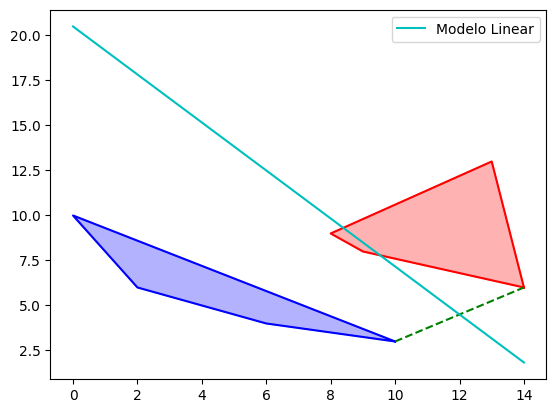

In [642]:
# Gerar pontos aleatórios para testar
classe_1 = [Ponto(random.randint(0, 10), random.randint(0, 10)) for _ in range(5)]
classe_2 = [Ponto(random.randint(5, 15), random.randint(5, 15)) for _ in range(5)]

plot_modelo(classe_1, classe_2)

In [643]:
def plotar_classificacao(pontos1, pontos2, modelo):
    """
    Plota os pontos e a reta do modelo.
    
    :param pontos1: Lista de pontos da primeira classe.
    :param pontos2: Lista de pontos da segunda classe.
    :param modelo: Modelo linear obtido pela função construir_modelo_linear.
    """
    # Extrair coordenadas x e y dos pontos para plotagem
    x1, y1 = zip(*[(p.x, p.y) for p in pontos1])
    x2, y2 = zip(*[(p.x, p.y) for p in pontos2])
    
    # Plotar os pontos
    plt.scatter(x1, y1, color='blue', label='Classe 1')
    plt.scatter(x2, y2, color='red', label='Classe 2')
    
    # Plotar a reta do modelo
    if modelo[0] == 'vertical':
        plt.axvline(x=modelo[1], color='green', linestyle='--', label='Reta do Modelo')
    else:
        # Criando uma sequência de valores x para a reta
        x_reta = list(range(int(min(x1 + x2)) - 1, int(max(x1 + x2)) + 2))
        y_reta = [modelo[0] * x + modelo[1] for x in x_reta]
        
        plt.plot(x_reta, y_reta, color='green', linestyle='--', label='Reta do Modelo')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title('Classificação de Pontos com Modelo Linear')
    plt.grid(True)
    plt.show()

[[(3.2628272577415722, 0.16340502488047026), (4.971299110086648, 0.7117504497949745)], [(4.971299110086648, 0.7117504497949745), (4.749969452642818, 4.6525043526602925)], [(4.749969452642818, 4.6525043526602925), (4.617319949752591, 4.957391970675481)], [(4.617319949752591, 4.957391970675481), (0.3500581575865497, 4.847211723854064)], [(0.3500581575865497, 4.847211723854064), (0.143484857962346, 4.745773974893005)], [(0.143484857962346, 4.745773974893005), (0.046687876134279827, 4.468334334903449)], [(0.046687876134279827, 4.468334334903449), (0.12053988181396635, 3.277400190331619)], [(0.12053988181396635, 3.277400190331619), (0.5496700519208936, 0.3205006003217631)], [(0.5496700519208936, 0.3205006003217631), (0.8482325887171072, 0.28048370477056717)], [(0.8482325887171072, 0.28048370477056717), (3.0466514574632897, 0.17324274477005852)], [(3.0466514574632897, 0.17324274477005852), (3.2628272577415722, 0.16340502488047026)], [(3.2628272577415722, 0.16340502488047026), (3.262827257741

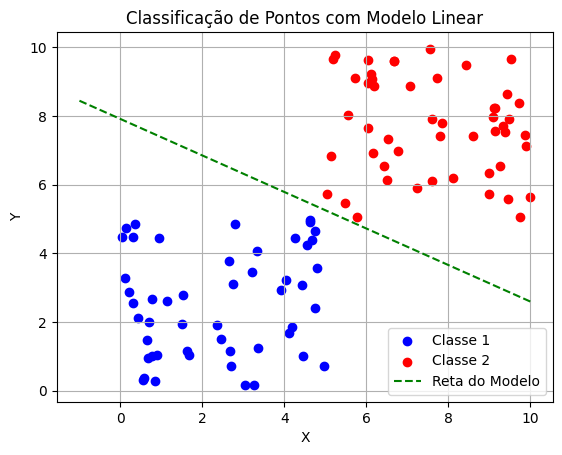

In [644]:
def gerar_pontos_aleatorios(qtd_pontos, limite_inf, limite_sup):
    """
    Gera uma lista de pontos aleatórios.
    
    :param qtd_pontos: Número de pontos a serem gerados.
    :param limite_inf: Tuple contendo os limites inferiores (x, y).
    :param limite_sup: Tuple contendo os limites superiores (x, y).
    :return: Lista de pontos aleatórios.
    """
    pontos = []
    for _ in range(qtd_pontos):
        x = random.uniform(limite_inf[0], limite_sup[0])
        y = random.uniform(limite_inf[1], limite_sup[1])
        pontos.append(Ponto(x, y))
    return pontos

# Exemplo de uso:
pontos1_aleatorios = gerar_pontos_aleatorios(50, (0, 0), (5, 5))
pontos2_aleatorios = gerar_pontos_aleatorios(50, (5, 5), (10, 10))
modelo = construir_modelo_linear(pontos1_aleatorios, pontos2_aleatorios)

if modelo:
    plotar_classificacao(pontos1_aleatorios, pontos2_aleatorios, modelo)